# MAST30034 Applied Data Science Project 2
## Analysis Notebook

In [1]:
# Import libraries
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import isnan, when, count, col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import title

import geopandas as gpd
import folium

# Create spark session
spark = (
    SparkSession.builder.appName("Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

# Read in preprocessed data
data = spark.read.parquet('../data/curated/final_data.parquet')
sf = gpd.read_file("../data/external/shapefile/SA2_2021_AUST_GDA2020.shp")
external_data = pd.read_parquet('../data/curated/external_data.parquet')
data_pd = pd.read_parquet('../data/curated/final_data.parquet')

### **1. Outlier Analysis**

Questions:
* If you found NULL values after you joined the datasets, what did you do with them? How many were there?

    * After joining the datasets, there were 750332 null values in the SA2 dataset and 182 in the origninal dataset, these comprised of approximatley 2% of the total dataset. for null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated.

* Was there any missing data that shouldn’t be missing after joining to your externaldataset? If anything was missing, how much was there and what did you do about it?

    * There was only 182 rows of missing data once joined, due to the extremely low number and the fact that the whole purchase was null, they were removed.

* If you decided to omit outliers, what does the distribution look like prior and after?


In [2]:
# data.limit(5)
# data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])

#### 1.1 Customer Details

- **SA2_CODE_2021 / SA2_NAME_2021**: For null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated (see `null_imputation.py`).

- **Postcode**: Remove all instances in a null postcode as there is not way to determine the location of the purchase with the postcode. According to AusPost, all post between 1000-9999 are valid, thus we will keep all.

-  **Gender**: No outliers found.

In [3]:
data = data.na.drop(subset=["postcode"])

print(data.agg({'postcode': 'min'}))
print(data.agg({'postcode': 'max'}))

data.groupBy('gender').count()

+-------------+
|min(postcode)|
+-------------+
|         1001|
+-------------+



+-------------+
|max(postcode)|
+-------------+
|         9999|
+-------------+



gender,count
Undisclosed,1623315
Female,7115735
Male,7281300


#### 1.2 Order Details

-  **Order Date**: Based on the output all values are in 2021.

- **ABN**: All ABNs are 11 digits long, thus we will verify this.

- **Dollar Value**:
    - Instances < $0.05 seem unreasonable due the the limited things you can buy for 5c, thus they will be removed from the dataset.

    - Instances > $50,000 come from anitque shops or jewelry shops and thus is plausible for the individuals to be spending large amounts of money. 

In [4]:
print(data.agg({'order_datetime': 'min'}))
print(data.agg({'order_datetime': 'max'}))

print(data.agg({'merchant_abn': 'min'}))
print(data.agg({'merchant_abn': 'max'}))

print(data.agg({'dollar_value': 'min'}))
print(data.agg({'dollar_value': 'max'}))

+-------------------+
|min(order_datetime)|
+-------------------+
|         2021-02-28|
+-------------------+



+-------------------+
|max(order_datetime)|
+-------------------+
|         2022-10-26|
+-------------------+



+-----------------+
|min(merchant_abn)|
+-----------------+
|      10023283211|
+-----------------+



+-----------------+
|max(merchant_abn)|
+-----------------+
|      99990536339|
+-----------------+



+--------------------+
|   min(dollar_value)|
+--------------------+
|9.756658099412162E-8|
+--------------------+



+------------------+
| max(dollar_value)|
+------------------+
|105193.88578925544|
+------------------+



In [5]:
# Check instances < $0.05
data.where(col("dollar_value") <= 0.05).limit(10)

22/09/14 12:42:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


SA2_CODE_2021,postcode,consumer_id,user_id,merchant_abn,order_datetime,dollar_value,order_id,is_fraud,fraud_probability,name,tags,take rate,revenue level,consumer_name,address,gender,SA2_NAME_2021,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_mortgage_repay_monthly,Median_age_persons,Median_tot_hhd_inc_weekly,Average_household_size,Year_12_Highest_Level_of_School,Did_Not_Attend_School,TOT_P_P,state
405041127,5572,1900,4615,46804135891,2021-11-10,0.033637596592583904,5475784d-bfc0-4cf...,false,0.01,Suspendisse Dui C...,"[opticians, opti...",2.93,c,Kimberly Ray,46840 Jennifer Knoll,Female,Yorke Peninsula -...,555.0,200.0,1000.0,57.0,1003.0,2.0999999046325684,2103.0,6.0,7458.0,SA
206011106,3057,20117,1890,19933438190,2021-09-07,0.04458309415200386,2edd0a67-9966-4cf...,false,0.01,Dui Nec Corporation,[tent and awning ...,2.22,c,Kristen Sheppard,5331 Alexander Or...,Female,Brunswick East,1244.0,421.0,2000.0,33.0,2087.0,2.0,9418.0,106.0,12738.0,VIC
null,1196,22567,14631,30801495844,2021-10-16,0.039112684075111974,2f83fb78-982e-49b...,false,0.01,Nunc Ullamcorper ...,"[opticians, opti...",4.58,b,Charles Macias,00433 Jonathan Locks,Male,New South Wales,857.9522855470326,405.5064209611567,2097.353104552186,41.5431947325375,1851.6776616552597,2.5610279887795975,5810.870648143221,97.20094405000843,12293.507334864831,NSW
108021159,2447,36677,934,56945597985,2022-03-28,0.001771595203417006,49a98147-ba38-4c5...,false,0.01,Sem LLP,"[cable, satellit...",6.53,a,Brandon Ramirez,443 Derek Hollow,Male,Nambucca Heads Su...,554.0,300.0,1400.0,50.0,1111.0,2.4000000953674316,2492.0,21.0,8102.0,NSW
509031246,6306,42120,3979,71528203369,2021-03-11,0.009132614287011825,57991730-1c57-42d...,false,0.01,Ipsum Primis Asso...,"[watch, clock, ...",6.94,a,Shannon Perez,04321 Tina Valleys,Female,Brookton,693.0,200.0,1083.0,50.0,1258.0,2.299999952316284,1149.0,9.0,3504.0,WA
407021155,5273,63722,6774,80324045558,2022-02-10,0.02402750403118358,6ed55301-4017-471...,false,0.01,Ipsum Dolor Sit C...,"[gift, card, no...",1.47,c,Michael Vincent,8972 Sawyer Summi...,Male,Naracoorte Surrounds,874.0,150.0,900.0,44.0,1632.0,2.5,885.0,11.0,2395.0,SA
null,1715,73669,7036,80324045558,2022-02-06,0.02019492433024695,c4809a33-d3f5-4be...,false,0.01,Ipsum Dolor Sit C...,"[gift, card, no...",1.47,c,Scott Rodriguez,5597 Stevenson Wells,Male,New South Wales,857.9522855470326,405.5064209611567,2097.353104552186,41.5431947325375,1851.6776616552597,2.5610279887795975,5810.870648143221,97.20094405000843,12293.507334864831,NSW
109021179,2736,88387,4144,62773208456,2022-05-13,0.021859074585630942,3fc99f44-b03e-477...,false,0.01,Ac Institute,"[watch, clock, ...",2.62,c,Jeffrey Williams,3701 Black Loop S...,Male,Wentworth-Balrana...,746.0,200.0,1083.0,43.0,1404.0,2.5,937.0,24.0,3648.0,NSW
null,1122,90124,8842,83147343261,2022-09-06,0.04918700728492373,20b85fd5-d0a9-430...,false,0.01,Porttitor Sceleri...,"[watch, clock, ...",6.68,a,Ann Brown,228 Jordan Springs,Female,New South Wales,857.9522855470326,405.5064209611567,2097.353104552186,41.5431947325375,1851.6776616552597,2.5610279887795975,5810.870648143221,97.20094405000843,12293.507334864831,NSW
215031400,3530,115106,14672,57083783235,2022-07-21,0.048756768032216166,7c8b6827-f418-4ce...,false,0.01,Dignissim Magna A...,[tent and awning ...,5.97,a,Warren Johnson,87141 Pratt Overpass,Male,Buloke,618.0,158.0,734.0,52.0,1089.0,2.200000047683716,1850.0,10.0,6184.0,VIC


In [6]:
# Number of instances < $0.05
data.where(col("dollar_value") <= 0.05).count()

5783

In [6]:
# Remove instances < $0.05
data  = data.where(col('dollar_value') >= 0.05)

In [8]:
# Check instances > $50000
data.where(col("dollar_value") >= 50000).limit(10)

SA2_CODE_2021,postcode,consumer_id,user_id,merchant_abn,order_datetime,dollar_value,order_id,is_fraud,fraud_probability,name,tags,take rate,revenue level,consumer_name,address,gender,SA2_NAME_2021,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_mortgage_repay_monthly,Median_age_persons,Median_tot_hhd_inc_weekly,Average_household_size,Year_12_Highest_Level_of_School,Did_Not_Attend_School,TOT_P_P,state
407021155,5271,1253388,15504,83199298021,2022-06-19,57996.7495260236,dfd47864-2440-4de...,false,0.01,Ligula Elit Preti...,[antique shops - ...,4.82,b,John Diaz,13195 Cole Spring...,Male,Naracoorte Surrounds,874.0,150.0,900.0,44.0,1632.0,2.5,885.0,11.0,2395.0,SA
null,4003,10448,21419,23686790459,2021-12-10,67706.74019097649,079cc8aa-eadd-4f3...,true,79.4543441508535,null,null,null,null,Janet Warner,9051 Neal Mission,Female,Queensland,775.9091154459247,307.8684087575766,1547.2741572923612,41.434288111746085,1602.4911151760195,2.5182192692675014,3858.6364421866238,37.58904398786228,9316.330693963611,QLD
null,4003,10448,21419,23686790459,2021-12-10,67706.74019097649,079cc8aa-eadd-4f3...,true,79.4543441508535,null,null,null,null,Janet Warner,9051 Neal Mission,Female,Queensland,775.9091154459247,307.8684087575766,1547.2741572923612,41.434288111746085,1602.4911151760195,2.5182192692675014,3858.6364421866238,37.58904398786228,9316.330693963611,QLD
208011169,3186,1242133,6228,82999039227,2021-12-19,77320.86980270348,4091b4ae-a26b-478...,true,94.1347004808891,null,null,null,null,Mr. James Norton DDS,558 Chang Land,Male,Brighton (Vic.),1265.0,600.0,3467.0,48.0,2718.0,2.4000000953674316,14507.0,50.0,22758.0,VIC
208011169,3186,1242133,6228,82999039227,2021-12-19,77320.86980270348,4091b4ae-a26b-478...,true,94.1347004808891,null,null,null,null,Mr. James Norton DDS,558 Chang Land,Male,Brighton (Vic.),1265.0,600.0,3467.0,48.0,2718.0,2.4000000953674316,14507.0,50.0,22758.0,VIC
212021297,3803,537248,16391,58495294020,2021-03-13,57541.59534772687,8717210d-9072-4e3...,false,0.01,Diam Nunc Associates,"[jewelry, watch,...",3.98,b,Dr. Caleb Briggs,27541 Summers All...,Male,Hallam,607.0,361.0,1700.0,36.0,1496.0,3.0,5059.0,431.0,11472.0,VIC
301011002,4153,1370812,16469,83199298021,2021-07-10,54703.721746700794,90506a27-793e-410...,false,0.01,Ligula Elit Preti...,[antique shops - ...,4.82,b,Ruth Roberts,58933 Francisco D...,Female,Belmont - Gumdale,951.0,450.0,2268.0,41.0,2588.0,3.0999999046325684,4005.0,43.0,7550.0,QLD
307011177,4454,882166,5606,99989036621,2021-10-17,56552.39444305644,63e74dd2-a1e4-42b...,true,18.21089142894488,null,null,null,null,Mercedes Liu,18523 Bradford Ju...,Undisclosed,Roma Surrounds,770.0,155.0,1114.0,42.0,1436.0,2.5,1802.0,20.0,5989.0,QLD
307011177,4454,882166,5606,99989036621,2021-10-17,56552.39444305644,63e74dd2-a1e4-42b...,true,18.21089142894488,null,null,null,null,Mercedes Liu,18523 Bradford Ju...,Undisclosed,Roma Surrounds,770.0,155.0,1114.0,42.0,1436.0,2.5,1802.0,20.0,5989.0,QLD
null,6827,371662,8005,62789659343,2022-09-04,53367.73947743792,8f56093e-3f35-4d3...,false,0.01,null,null,null,null,Joshua Ochoa,007 Maria Canyon,Male,Western Austraia,873.8301297935628,273.04134233114024,1546.893796004206,41.89102524153908,1687.1407287273978,2.457618368202523,3608.7067319344,38.97249961173711,8296.494054384502,WA


### **2. Transaction Analysis**

#### 2.1 Transaction Location

<AxesSubplot:title={'center':'Top 10 Merchants by Transaction Volume'}, ylabel='merchant_abn'>

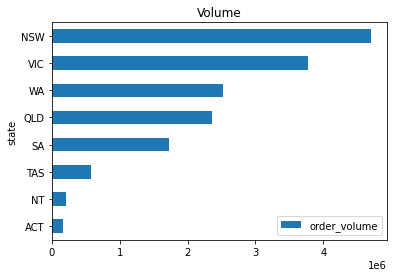

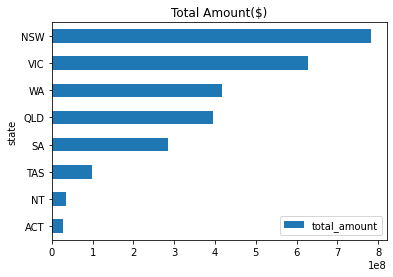

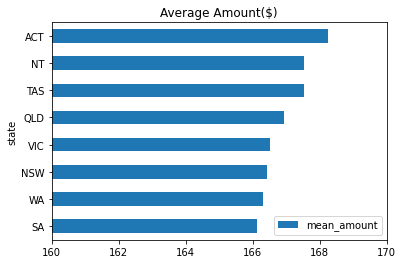

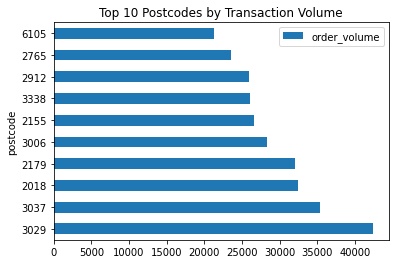

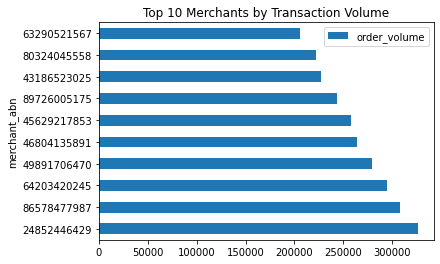

In [23]:
# Aggregate Data
# By State
transaction_by_state = data \
                    .groupBy("state") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("state") \
                    .toPandas()

# By Postcode
transaction_by_postcode = data \
                    .groupBy("postcode") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("postcode") \
                    .toPandas()

# By Merchant
transaction_by_merchant = data \
                    .groupBy("merchant_abn") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("merchant_abn") \
                    .toPandas()

# Generate plots
transaction_by_state = transaction_by_state.sort_values(by='order_volume')
transaction_by_state.plot(x='state', y='order_volume', kind="barh", title='Volume')
transaction_by_state = transaction_by_state.sort_values(by='total_amount')
transaction_by_state.plot(x='state', y='total_amount', kind="barh", title='Total Amount($)')
transaction_by_state = transaction_by_state.sort_values(by='mean_amount')
transaction_by_state.plot(x='state', y='mean_amount', kind="barh", xlim=[160,170], title='Average Amount($)')

transaction_by_postcode = transaction_by_postcode.sort_values(by='order_volume', ascending=False)
transaction_by_postcode[:10].plot(x='postcode', y='order_volume', kind="barh", title='Top 10 Postcodes by Transaction Volume')

transaction_by_merchant = transaction_by_merchant.sort_values(by='order_volume', ascending=False)
transaction_by_merchant[:10].plot(x='merchant_abn', y='order_volume', kind="barh", title='Top 10 Merchants by Transaction Volume')

#### 2.2 Transaction Datetime

##### 2.2.1 Time of Year
(All instances are from 2021)

Text(0, 0.5, 'Average Amount')

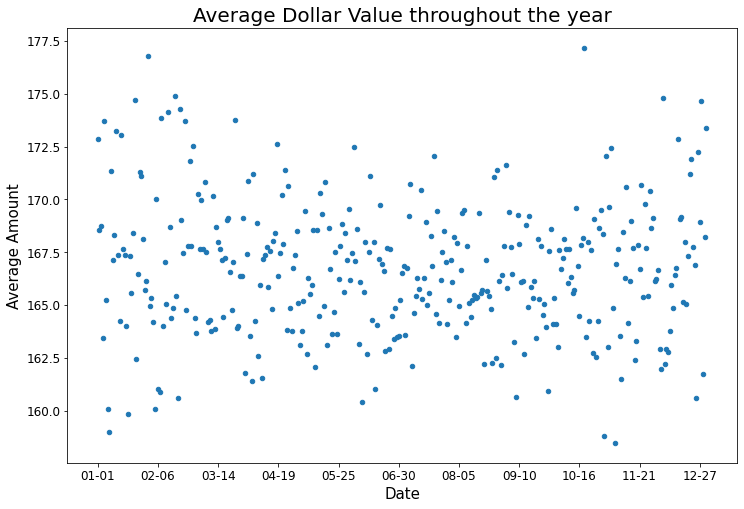

In [10]:
data = data.withColumn('date', F.regexp_replace('order_datetime', r'(\d{4})-', ''))
data = data.withColumn('year', F.regexp_replace('order_datetime', r'(-\d{2}-\d{2})', ''))

# data.groupBy("date").sum('dollar_value')

date_df = data[['date', 'dollar_value']] \
                .groupby('date') \
                .agg(
                    {
                        'dollar_value': 'sum', 
                        'date': 'count'
                    }
                )
date_df = date_df.withColumn('avg_dollar_value', date_df['sum(dollar_value)'] / date_df['count(date)'])
date_df.drop('sum(dollar_value)', 'count(date)')
date_df = date_df.toPandas()

date_df = date_df.sort_values(by = ['date'])
x = date_df['date']
y = date_df['avg_dollar_value']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"date": x, "avg_dollar_value":y})
time_df.plot(kind='scatter', x= 'date', y= 'avg_dollar_value', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) // 10])
ax.set_ylabel("Average Amount", fontsize = 15)

##### 2.2.2 Day of the week

Text(0, 0.5, 'Average Amount')

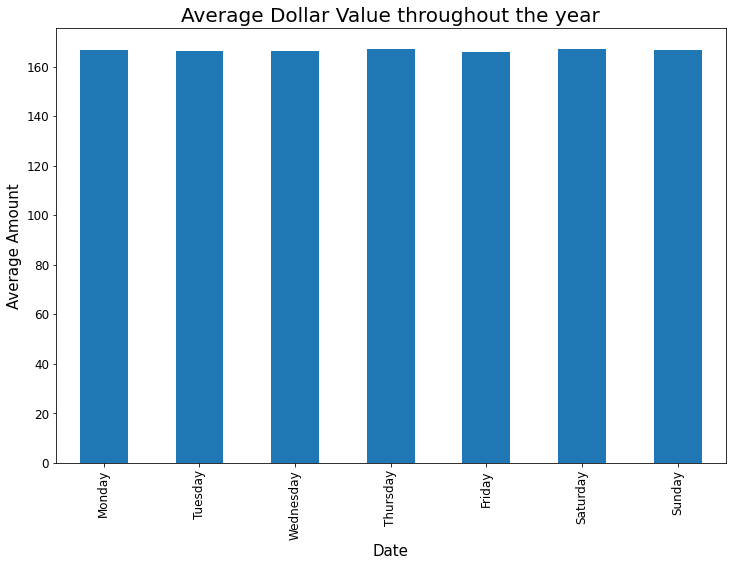

In [11]:
data_pd['order_datetime'] = pd.to_datetime(data_pd['order_datetime'])
data_pd['day_of_week'] = data_pd['order_datetime'].dt.day_name()

date_df = data_pd[['day_of_week', 'dollar_value']] \
                .groupby('day_of_week') \
                .agg(
                    {
                        'dollar_value': 'sum', 
                        'day_of_week': 'count'
                    }
                )

date_df['avg_dollar_value'] = date_df['dollar_value']/date_df['day_of_week']
date_df = date_df.drop(columns = ['dollar_value', 'day_of_week'])
#date_df = date_df.drop('day_of_week_count')
#date_df.rename(columns = {'day_of_week':'count'})
#date_df['count'] = date_df['day_of_week']
#date_df.drop('day_of_week')
#date_df
date_df = date_df.reset_index()
dotw = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_df['Date'] = pd.Categorical(date_df['day_of_week'], categories=dotw, ordered=True)
date_df = date_df.sort_values('Date')

x = date_df['day_of_week']
y = date_df['avg_dollar_value']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"day_of_week": x, "avg_dollar_value":y})
time_df.plot(kind='bar', x= 'day_of_week', y= 'avg_dollar_value', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_ylabel("Average Amount", fontsize = 15)

#### 2.3 Distribution of Dollar Value

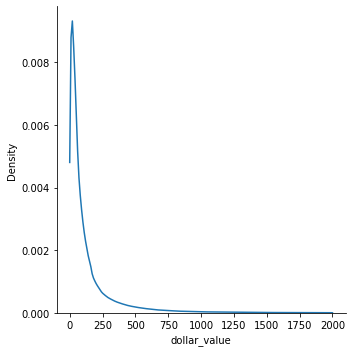

In [16]:
less_than_2000 = data_pd[data_pd['dollar_value']<2000]
sns.displot(less_than_2000, x="dollar_value", kind="kde", cut = 0)

#### 2.4 Distribution of Merchant Revenue Levels

In [17]:
revenue_level = data.select('revenue level').toPandas()

# Distribution of revenue levels
rv_count = revenue_level.value_counts(normalize=True, sort=False)
rv_count

revenue level
a                0.448911
b                0.288073
c                0.244151
d                0.010039
e                0.008827
dtype: float64

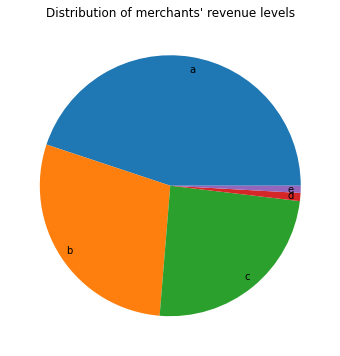

In [18]:
# Plot pie chart for distribution of revenue levels
plt.figure(figsize=(10,6))
plt.pie(rv_count, labels=['a','b','c','d','e'], labeldistance=0.9)
plt.title('Distribution of merchants\' revenue levels')
plt.show()

### **3. Correlation Analysis**

<AxesSubplot:>

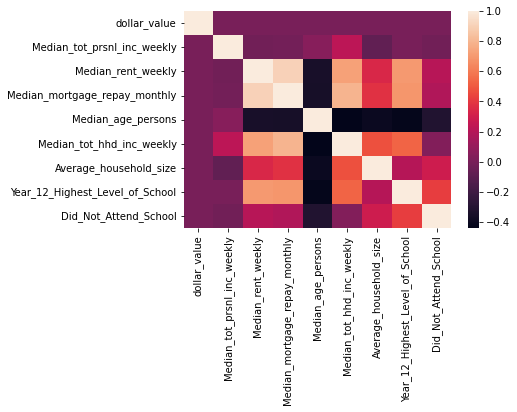

In [24]:
# Select attributes to check correlation with transaction amount
df_corr = data.select('dollar_value', 
                      'Median_tot_prsnl_inc_weekly', 
                      'Median_rent_weekly', 
                      'Median_mortgage_repay_monthly', 
                      'Median_age_persons', 
                      'Median_tot_hhd_inc_weekly', 
                      'Average_household_size', 
                      'Year_12_Highest_Level_of_School', 
                      'Did_Not_Attend_School').toPandas()
                      
# Create heatmap of correlation
sns.heatmap(df_corr.corr())

### **4. Geospatial Analysis**

Removed From Visualisation for Income (Extremely High Household Income): 
- 797979799 - Migratory - Offshore - Shipping (NT)
- 206041507	- Royal Botanic Gardens Victoria (VIC)
- 801011012 - Gooromon (ACT)
- 503021037 - Kings Park (WA)
- 801011111 - Molonglo Corridor (ACT)

It is also worth noting that there's no transaction data from the state of NT, based on SA2

In [17]:
data = data.withColumn("take_rate*dollar_value", F.col("take rate")*F.col("dollar_value"))
SA2_data = data \
            .groupBy("SA2_CODE_2021") \
            .agg(
                F.mean("dollar_value").alias("mean_amount"),
                F.sum("dollar_value").alias("total_amount"),
                F.count("order_id").alias("order_volume"),
                F.mean("take_rate*dollar_value").alias("mean_take_rate*dollar_value"),
            ) \
            .orderBy("SA2_CODE_2021") \
            .toPandas()

SA2_data = SA2_data.loc[SA2_data['SA2_CODE_2021'].notnull()]
# SA2_data.sort_values(by='total_amount')

# Code from MAST30034 Applied Data Science Tutorial 2
# Convert the geometry shape to to latitude and longitude
sf = sf[['SA2_CODE21','geometry']]
sf['geometry'] = sf['geometry'] \
                    .to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(sf)
geoJSON = gdf[['SA2_CODE21', 'geometry']].to_json()

external_data = external_data.loc[(external_data['SA2_CODE_2021'].astype('int') != 797979799) & 
                                (external_data['SA2_CODE_2021'].astype('int') != 206041507) &
                                (external_data['SA2_CODE_2021'].astype('int') != 801011012) &
                                (external_data['SA2_CODE_2021'].astype('int') != 503021037) &
                                (external_data['SA2_CODE_2021'].astype('int') != 801011111) ]
# external_data.sort_values(by='Median_tot_hhd_inc_weekly')

#### 4.1 Median Weekly Houshold Income By SA2

In [22]:
m1 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c1 = folium.Choropleth(
    geo_data=geoJSON,
    name='Median Weekly Houshold Income By SA2',
    data=external_data,
    columns=['SA2_CODE_2021', 'Median_tot_hhd_inc_weekly'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Income By SA2',
    prefer_canvas=True
)

c1.add_to(m1)

m1.save("../plots/income.html")

#### 4.2 Transaction Volume By SA2

In [21]:
m2 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c2 = folium.Choropleth(
    geo_data=geoJSON,
    name='Transaction Volume By SA2',
    data=SA2_data.reset_index(),
    columns=['SA2_CODE_2021', 'order_volume'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Transaction Volume By SA2',
    prefer_canvas=True
)

c2.add_to(m2)

m2.save("../plots/volume.html")

#### 4.3 Average Transaction Amount By SA2

In [87]:
m3 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c3 = folium.Choropleth(
    geo_data=geoJSON,
    name='Average Transaction Amount By SA2',
    data=SA2_data.reset_index(),
    columns=['SA2_CODE_2021', 'mean_amount'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Average Transaction Amount By SA2'
)

c3.add_to(m3)

m3.save("../plots/avg_amount.html")

#### 4.4 Average Take Rate * Dollar Value By SA2

In [88]:
m4 = folium.Map(location=[-33.8, 151.2],
                  tiles="cartodbpositron", zoom_start=4)

c4 = folium.Choropleth(
    geo_data=geoJSON,
    name='Average Take Rate * Dollar Value By SA2',
    data=SA2_data.reset_index(),
    columns=['SA2_CODE_2021', 'mean_amount'],
    key_on='feature.properties.SA2_CODE21',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Average Take Rate * Dollar Value By SA2'
)

c4.add_to(m4)

m4.save("../plots/avg_take_rate_dollar_val.html")

### **5. Output Cleaned Data**

In [9]:
data.write.mode('overwrite').parquet('../data/curated/cleaned_data.parquet')